<a href="https://colab.research.google.com/github/evanphilipsmith/infant-cry-prediction/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies and Imports

In [ ]:
![ ! -f utils.py ] && wget https://raw.githubusercontent.com/evanphilipsmith/infant-cry-prediction/main/utils.py
![ ! -f dataset.py ] && wget https://raw.githubusercontent.com/evanphilipsmith/infant-cry-prediction/main/dataset.py
![ ! -f network.py ] && wget https://raw.githubusercontent.com/evanphilipsmith/infant-cry-prediction/main/network.py
![ ! -f pretrained_model.pth ] && wget https://raw.githubusercontent.com/evanphilipsmith/infant-cry-prediction/main/pretrained_model.pth
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
![ ! -d donateacry-corpus ] && git clone https://github.com/gveres/donateacry-corpus.git

In [1]:
import gc
import torch
import numpy as np
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

from dataset import DonateACryDataset
from network import RNN
from utils import plot_loss, plot_accuracy, train, evaluate, load_checkpoint

assert torch.cuda.is_available(), "Select a GPU from Runtime -> Change runtime type"

# Train

In [2]:
clean_dirs = ['./donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/']
clean_train_data = DonateACryDataset(clean_dirs, train=True, drop_hungry=0.75)
clean_test_data = DonateACryDataset(clean_dirs, train=False)

assert clean_train_data.target_decoding == clean_test_data.target_decoding

print(clean_train_data.value_counts())
print()
print(clean_test_data.value_counts())

hungry           76
discomfort       22
tired            19
belly pain       13
needs burping     6
Name: target, dtype: int64

hungry           77
tired             5
discomfort        5
belly pain        3
needs burping     2
Name: target, dtype: int64


In [3]:
def run(checkpoint=None, num_epochs=100, save_checkpoints=True):
    gc.collect()
    batch_size = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clean_train_loader = DataLoader(clean_train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    clean_test_loader = DataLoader(clean_test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    if checkpoint:
        model = load_checkpoint(checkpoint).to(device)
    else:
        model = RNN(hidden_size=80, output_size=5, n_layers=2, batch_size=batch_size, bidirectional=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = torch.nn.CrossEntropyLoss()

    losses = train(clean_train_loader, clean_test_loader, num_epochs, model, optimizer, loss, device, save=save_checkpoints)
    return model, losses

In [6]:
model, metrics = run(num_epochs=2, save_checkpoints=False)
train_losses, test_losses, train_accuracies, test_accuracies, test_preds = metrics

epoch 2/2, loss: 0.799: 100%|██████████| 456/456 [05:21<00:00,  2.62it/s]

# Results

num epochs trained 2
micro: 0.8369565217391305
macro: 0.1822485207100592
distribution of preds: (array([2]), array([184]))


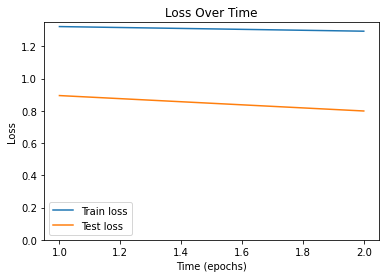

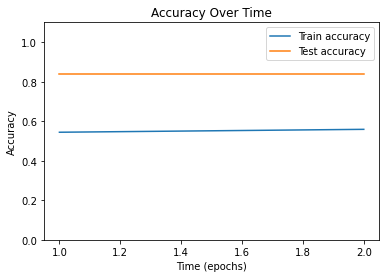

In [7]:
print('num epochs trained', model.num_epochs_trained)
print('micro:', f1_score(clean_test_data.data.target, test_preds[-1], average='micro'))
print('macro:', f1_score(clean_test_data.data.target, test_preds[-1], average='macro'))
print('distribution of preds:', np.unique(test_preds, return_counts=True))

plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)